In [1]:
import matplotlib.pyplot as plt
import pde
import numpy as np
import torch
import pandas as pd
from torch.nn import functional as F


from numpy import pi
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [27]:
def solveEquationPYPDE(variable, eq, ic="4*sech(x)", xrange=None, yrange=None, points=150, trange=pi/2):
    #initialize xrangenp.linspace(0, 10, 100).reshape(-1, 1)
    if xrange is None:
        xrange = [-5, 5]
    
    #eq is passed in as a string with x as the dependent variable
    eq = pde.PDE({variable: eq})
    
    if yrange is not None:
        grid = pde.grids.CartesianGrid([xrange, yrange], [points], periodic=[True, True])
    else:
        grid = pde.grids.CartesianGrid([xrange], [points],  periodic=True)
    
    field = pde.ScalarField.from_expression(grid, ic)
    bc = ["periodic", {'derivative': 'periodic'}]
    #field /= np.sqrt(field.to_scalar('norm_squared').integral.real)

    storage = pde.MemoryStorage()
    eq.solve(field, t_range=trange, dt=1e-6*pi/2, tracker=[storage.tracker(0.01)])
    
    return field, storage

In [28]:
s1, st1 = solveEquationPYPDE('phi', f"0.5 * I * laplace(phi) + I * (phi*conjugate(phi)) * phi")

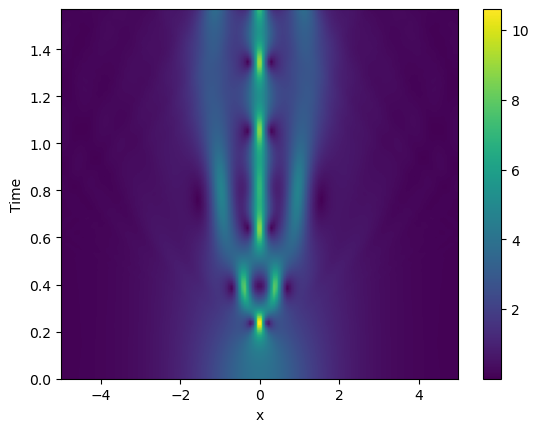

In [29]:
pde.plot_kymograph(st1)

In [5]:
x = s1.get_line_data()['data_x'].reshape(-1,1) # X x 1
t = np.array(st1.times).reshape(-1,1) # T x 1
x_grid, t_grid = np.meshgrid(x, t)


phi = np.array(st1.data)
u = np.real(phi) #.flatten().reshape(-1,1)[::10].reshape(79,30)   #.flatten()[:,None]
v = np.imag(phi) #.flatten().reshape(-1,1)[::10].reshape(79,30)  #.flatten()[:,None]

#plt.pcolormesh(x_grid, t_grid, np.sqrt(u**2 + v**2))

##Generate the two indices
idx1 = np.random.choice(x_grid.shape[0], 105, replace=False)
idx1 = np.sort(idx1)
idx2 = np.random.choice(x_grid.shape[1], 100, replace=False)
idx2 = np.sort(idx2)

def gen_train(grid):
    grid_new = grid[idx1]
    grid_new = grid_new[:,idx2]
    return grid_new
    
x_train, t_train, u_train, v_train = gen_train(x_grid), gen_train(t_grid), gen_train(u), gen_train(v)

In [6]:
## reshape to feed into model
x_train = x_train.flatten()[:,None]
t_train = t_train.flatten()[:,None]

u_train = u_train.flatten()[:,None]
v_train = v_train.flatten()[:,None]

In [7]:
## boilerplate stuff for GPU...
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

## create gridmesh for plotting
x_axis = torch.linspace(-5, 5, 100)
t_axis = torch.linspace(0, pi/2, 100)

x_grid, t_grid = torch.meshgrid(x_axis, t_axis, indexing='xy')
xt_pairs = torch.stack((x_grid, t_grid), dim=2)
xt_pairs = xt_pairs.reshape(xt_pairs.shape[0] * xt_pairs.shape[1],2).to(device)

class PINN():
    def __init__(self, x, t, u, v, optim_name='adam', optim_steps=50000):
        self.x = torch.tensor(x, dtype=torch.float32, requires_grad=True, device=device)
        self.t = torch.tensor(t, dtype=torch.float32, requires_grad=True, device=device)
        
        ##Maybe these two also need requires_grad = True!!
        self.u = torch.tensor(u, dtype=torch.float32, device=device)
        self.v = torch.tensor(v, dtype=torch.float32, device=device)
        
        self.null = torch.zeros((self.x.shape[0],1), device=device)

        self.net_init()
        
        ## for learning the parameters?
        self.lam_1 = torch.nn.Parameter(torch.tensor(0., requires_grad=True, device=device))
        self.lam_2 = torch.nn.Parameter(torch.tensor(0., requires_grad=True, device=device))

        self.optim_name = optim_name
        self.optim_steps = optim_steps

        self.lams_1 =  []
        self.lams_2 =  []
        
        if not self.optim_name or self.optim_name == 'adam':
            self.optim = torch.optim.Adam(self.net.parameters(), lr=3e-4)
        elif self.optim_name == 'lbfgs':
            self.optim = torch.optim.LBFGS(self.net.parameters(),
                                   lr=15,
                                   max_iter=self.optim_steps,
                                   #max_eval=self.optim_steps,
                                   history_size=20,
                                   tolerance_grad=-1,
                                   tolerance_change=-0.5 * np.finfo(float).eps,
                                   line_search_fn='strong_wolfe'
                                  )

        
        self.mse = torch.nn.MSELoss()
        self.ls = 0
        self.ls_arr = torch.zeros(self.optim_steps)
        
        self.step = 0
    
    def net_init(self, dDim=256, act=torch.nn.Tanh):
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, dDim),act(),
            torch.nn.Linear(dDim, dDim),act(),
            torch.nn.Linear(dDim, dDim),act(),
            torch.nn.Linear(dDim, dDim),act(),
            torch.nn.Linear(dDim, dDim),act(),
            torch.nn.Linear(dDim, 2)
        )
        self.net.to(device)
    
    def func(self, x, t):
        preds = self.net(torch.hstack((x, t)))
        u, v = preds[:,0:1], preds[:,1:2]

        u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]

        v_t = torch.autograd.grad(v, t, torch.ones_like(v), create_graph=True)[0]
        v_x = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, torch.ones_like(v_x), create_graph=True)[0]

        ## define the two parts of the function being approximated...
        ## ...only to be immediately fucked by autograd, thank you very much
        f_u = u_t + self.lam_1 * v_xx + self.lam_2 * (torch.square(u) + torch.square(v))*v 
        f_v = v_t - self.lam_1 * u_xx - self.lam_2 * (torch.square(u) + torch.square(v))*u

        return u, v, f_u, f_v
        
    def closure(self):
        self.optim.zero_grad(set_to_none=True)

        u_pred, v_pred, f_u_pred, f_v_pred = self.func(self.x, self.t)
        
        u_loss = self.mse(u_pred, self.u)
        v_loss = self.mse(v_pred, self.v)
        f_u_loss = self.mse(f_u_pred, self.null)
        f_v_loss = self.mse(f_v_pred, self.null)
        
        self.ls = u_loss + v_loss + f_u_loss + f_v_loss
        self.ls.backward()

        self.lams_1.append(self.lam_1.item())
        self.lams_2.append(self.lam_2.item())
        
        self.ls_arr[self.step] = self.ls
        
        
        if not self.step % 1000:
            print(f"Data loss u: {u_loss.item()}, Function loss u: {f_u_loss.item()}")
            print(f"Data loss v: {v_loss.item()}, Function loss v: {f_v_loss.item()}")
            print(f"Step: {self.step}, Loss: {self.ls}")

        
        ## plot the solution and learned parameter values
        if not self.step % 5000:
            preds_twoaxes = pinn_adam.net(xt_pairs)
            preds = torch.sqrt(preds_twoaxes[:,0:1]**2 + preds_twoaxes[:,1:2]**2).reshape((100,100)).detach().cpu()
            plt.pcolormesh(x_grid, t_grid, preds)
            plt.show()
            
            plt.hlines(0.5, 0, len(self.lams_1), label='lam_1 true', color='tab:grey')
            plt.ylim(0,0.6)
            plt.plot(self.lams_1, label='lam_1 preds', color='tab:green')
            plt.legend()
            plt.show()
            
            plt.hlines(1.5, 0, len(self.lams_2), label='lam_2 true', color='tab:grey')
            plt.ylim(0,1.6)
            plt.plot(self.lams_2, label='lam_2 preds', color='tab:green')
            plt.legend()
            plt.show()
            
        
        self.step += 1
        return self.ls

    def train(self):
        self.net.train()
        if not self.optim_name or self.optim_name == 'adam':
            for i in range(self.optim_steps):
                self.optim.step(self.closure)
        elif self.optim_name == 'lbfgs':
            self.optim.step(self.closure)

In [8]:
pinn_adam = PINN(x_train, t_train, u_train, v_train,
                 optim_name = 'adam', optim_steps=150000)

Data loss u: 0.4296623766422272, Function loss u: 0.00010855067375814542
Data loss v: 0.4062029719352722, Function loss v: 5.972268263576552e-05
Step: 0, Loss: 0.8360336422920227


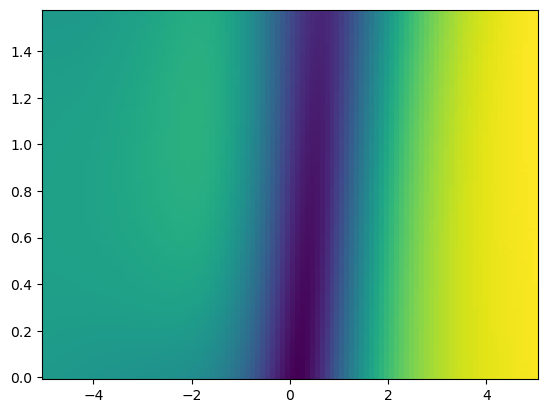

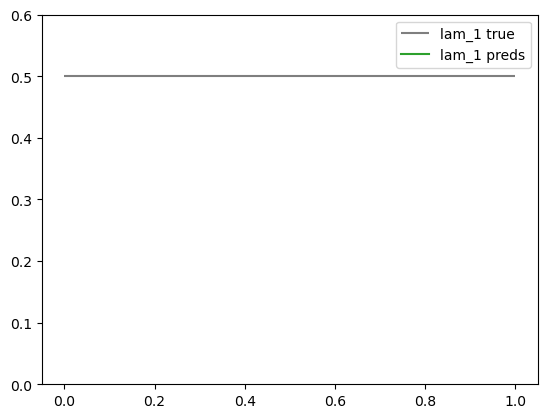

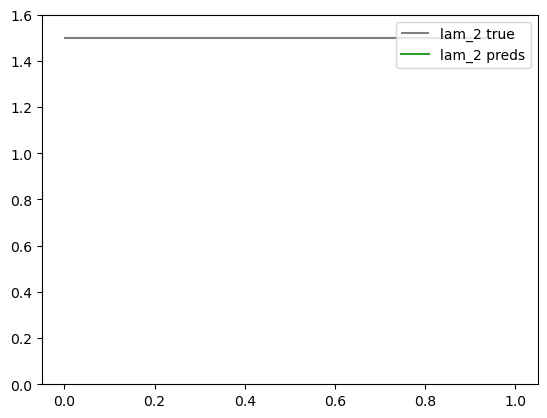

/usr/lib/python3.11/site-packages/torch/autograd/__init__.py:266: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [10500, 1], strides() = [1, 0]
param.sizes() = [10500, 1], strides() = [1, 0] (Triggered internally at /build/python-pytorch/src/pytorch-cuda/torch/csrc/autograd/functions/accumulate_grad.h:219.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Data loss u: 0.32174259424209595, Function loss u: 0.03193080425262451
Data loss v: 0.23420587182044983, Function loss v: 0.004397598560899496
Step: 1000, Loss: 0.5922768712043762
Data loss u: 0.31959301233291626, Function loss u: 0.032990459352731705
Data loss v: 0.22942085564136505, Function loss v: 0.006649600807577372
Step: 2000, Loss: 0.5886539220809937
Data loss u: 0.31925955414772034, Function loss u: 0.033082395792007446
Data loss v: 0.2291574627161026, Function loss v: 0.006770883221179247
Step: 3000, Loss: 0.588270366191864
Data loss u: 0.31872981786727905, Function loss u: 0.03346783295273781
Data loss v: 0.22903868556022644, Function loss v: 0.0068292077630758286
Step: 4000, Loss: 0.588065505027771
Data loss u: 0.31988784670829773, Function loss u: 0.03232026472687721
Data loss v: 0.22908049821853638, Function loss v: 0.006771240849047899
Step: 5000, Loss: 0.5880598425865173


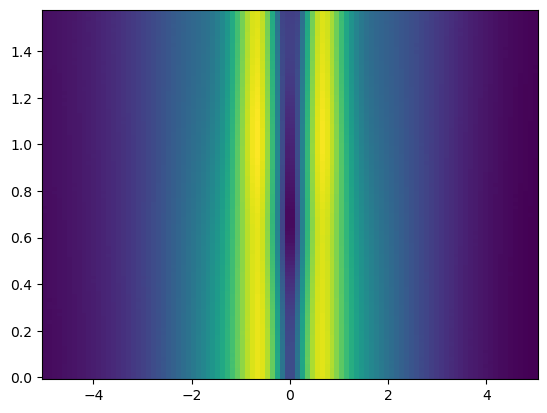

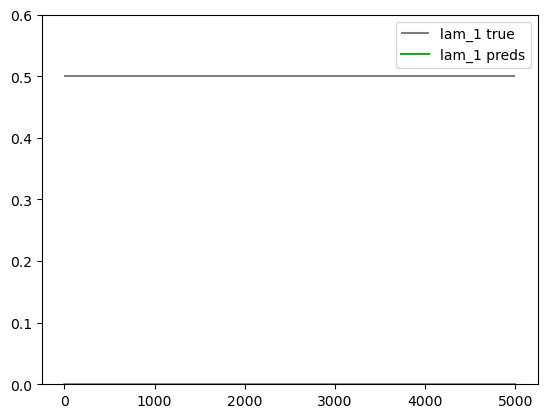

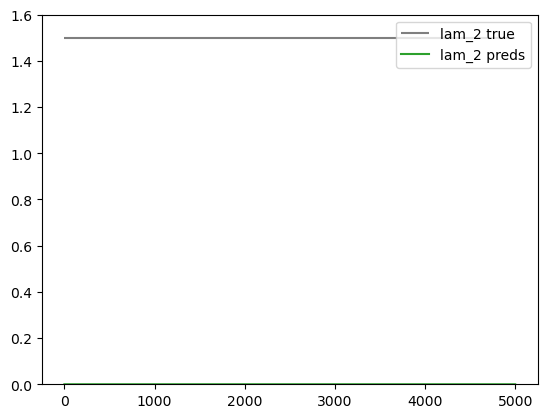

Data loss u: 0.3184182941913605, Function loss u: 0.03358696773648262
Data loss v: 0.22887109220027924, Function loss v: 0.006942362524569035
Step: 6000, Loss: 0.5878187417984009
Data loss u: 0.31781241297721863, Function loss u: 0.03407884016633034
Data loss v: 0.22861988842487335, Function loss v: 0.0070666358806192875
Step: 7000, Loss: 0.587577760219574
Data loss u: 0.31821417808532715, Function loss u: 0.033681098371744156
Data loss v: 0.2287987321615219, Function loss v: 0.006896565668284893
Step: 8000, Loss: 0.5875905752182007
Data loss u: 0.3176290988922119, Function loss u: 0.03418578952550888
Data loss v: 0.22863855957984924, Function loss v: 0.007029152940958738
Step: 9000, Loss: 0.5874825716018677
Data loss u: 0.3179786503314972, Function loss u: 0.03379496932029724
Data loss v: 0.22849808633327484, Function loss v: 0.007086339872330427
Step: 10000, Loss: 0.5873580574989319


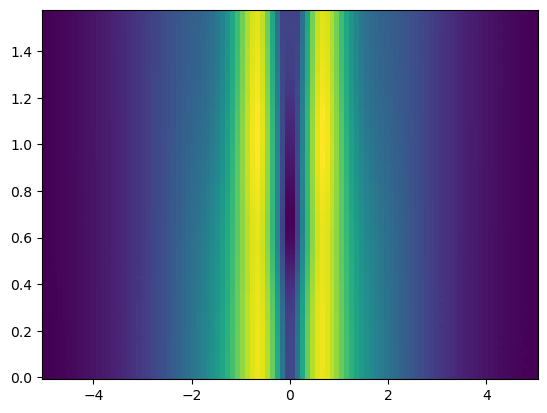

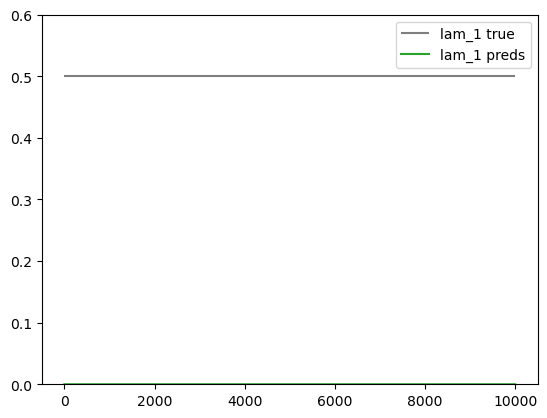

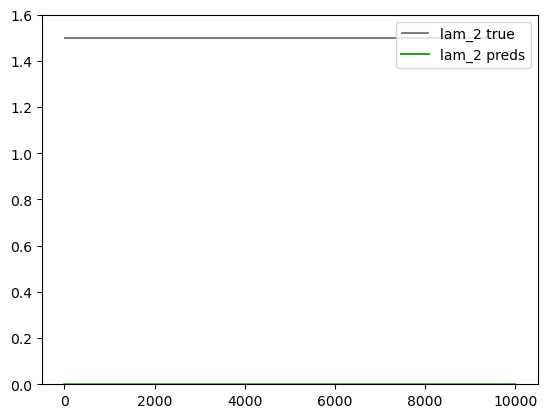

Data loss u: 0.317797988653183, Function loss u: 0.03345656767487526
Data loss v: 0.22834496200084686, Function loss v: 0.007077422924339771
Step: 11000, Loss: 0.5866768956184387
Data loss u: 0.3188858926296234, Function loss u: 0.033344000577926636
Data loss v: 0.2288857400417328, Function loss v: 0.0070116352289915085
Step: 12000, Loss: 0.5881272554397583


KeyboardInterrupt: 

In [9]:
pinn_adam.train()

In [ ]:
xt_pairs.shape

In [ ]:
pinn_adam.lams_2